<a href="https://colab.research.google.com/github/JasonX-CWJ/Mask_AI_Assignment/blob/main/mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Require Datasets and Models

In [1]:
!apt install -qq subversion 
!svn checkout https://github.com/vinuvish/Face-detection-with-OpenCV-and-deep-learning/trunk/models
!mv /content/models/deploy.prototxt.txt /content/models/deploy.prototxt

The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Selecting previously unselected package libapr1:amd64.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../libapr1_1.6.3-2_amd64.deb ...
Unpacking libapr1:amd64 (1.6.3-2) ...
Selecting previously unselected package libaprutil1:amd64.
Preparing to unpack .../libaprutil1_1.6.1-2_amd64.deb ...
Unpacking libaprutil1:amd64 (1.6.1-2) ...
Selecting previously unselected package libserf-1-1:amd64.
Preparing to unpack .../libserf-1-1_1.3.9-6_amd64.deb ...
Unpacking libserf-1-1:amd64 (1.3.9-6) ...
Selecting previously unselected

In [2]:
!svn checkout https://github.com/JasonX-CWJ/Mask_AI_Assignment/trunk/Data
!svn checkout https://github.com/JasonX-CWJ/Mask_AI_Assignment/trunk/sample_images

A    Data/Masked_Right
A    Data/Masked_Right/57000_Mask.jpg
A    Data/Masked_Right/57001_Mask.jpg
A    Data/Masked_Right/57002_Mask.jpg
A    Data/Masked_Right/57003_Mask.jpg
A    Data/Masked_Right/57004_Mask.jpg
A    Data/Masked_Right/57005_Mask.jpg
A    Data/Masked_Right/57006_Mask.jpg
A    Data/Masked_Right/57007_Mask.jpg
A    Data/Masked_Right/57008_Mask.jpg
A    Data/Masked_Right/57009_Mask.jpg
A    Data/Masked_Right/57010_Mask.jpg
A    Data/Masked_Right/57011_Mask.jpg
A    Data/Masked_Right/57012_Mask.jpg
A    Data/Masked_Right/57013_Mask.jpg
A    Data/Masked_Right/57014_Mask.jpg
A    Data/Masked_Right/57015_Mask.jpg
A    Data/Masked_Right/57016_Mask.jpg
A    Data/Masked_Right/57017_Mask.jpg
A    Data/Masked_Right/57018_Mask.jpg
A    Data/Masked_Right/57019_Mask.jpg
A    Data/Masked_Right/57020_Mask.jpg
A    Data/Masked_Right/57021_Mask.jpg
A    Data/Masked_Right/57022_Mask.jpg
A    Data/Masked_Right/57023_Mask.jpg
A    Data/Masked_Right/57024_Mask.jpg
A    Data/Masked_Right/5702

In [3]:
!rm -r /content/sample_data

# Training

In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32


In [6]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/Data"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


[INFO] loading images...


In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [8]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


9412608/9406464 [==============================] - 0s 0us/step


In [9]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] compiling model...
[INFO] training head...
Epoch 1/50
48/48 [==============================] - 52s 455ms/step - loss: 0.6522 - accuracy: 0.6680 - val_loss: 0.4890 - val_accuracy: 0.8428
Epoch 2/50
48/48 [==============================] - 20s 410ms/step - loss: 0.4444 - accuracy: 0.8379 - val_loss: 0.3792 - val_accuracy: 0.8686
Epoch 3/50
48/48 [==============================] - 19s 394ms/step - loss: 0.3455 - accuracy: 0.8689 - val_loss: 0.3287 - val_accuracy: 0.8814
Epoch 4/50
48/48 [==============================] - 19s 402ms/step - loss: 0.3070 - accuracy: 0.8900 - val_loss: 0.2972 - val_accuracy: 0.8918
Epoch 5/50
48/48 [==============================] - 19s 394ms/step - loss: 0.2817 - accuracy: 0.9045 - val_loss: 0.2724 - val_accuracy: 0.8943
Epoch 6/50
48/48 [==============================] - 19s 397ms/step - loss: 0.2495 - accuracy: 0.9144 - val_loss: 0.2531 - val_accuracy: 0.9021
Epoch 7/50
48/48 [==============================] - 19s 393ms/step - loss: 0.2339 - accuracy

In [10]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

Masked_Right       0.97      0.95      0.96       194
Masked_Wrong       0.95      0.97      0.96       194

    accuracy                           0.96       388
   macro avg       0.96      0.96      0.96       388
weighted avg       0.96      0.96      0.96       388

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


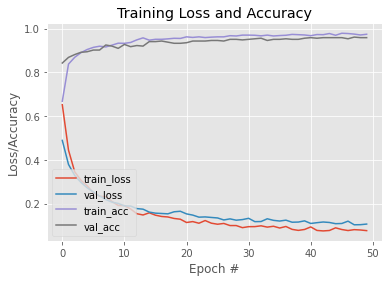

In [11]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Mask Detection Testing

In [16]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow


In [13]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["/content/models", "deploy.prototxt"])
weightsPath = os.path.sep.join(["/content/models",
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("mask_detector.model")

[INFO] loading face detector model...
[INFO] loading face mask detector model...


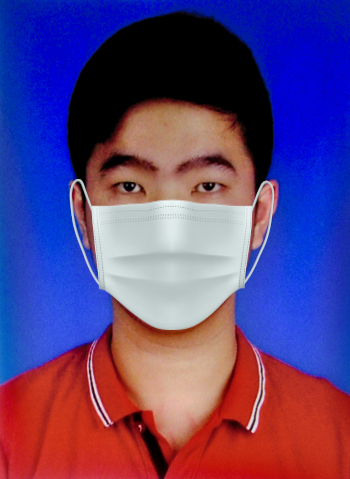

[INFO] computing face detections...


In [14]:
# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread("/content/sample_images/sample_1.jpg")
cv2_imshow(image)
orig = image.copy()
(h, w) = image.shape[:2]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

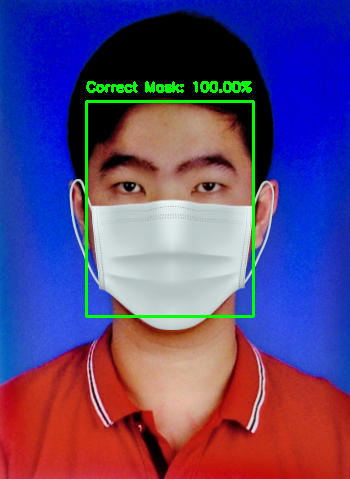

-1

In [15]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]
	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))
		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]; # cv2_imshow(image)
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)
		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]
		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Correct Mask" if mask > withoutMask else "Incorrect Mask"
		color = (0, 255, 0) if label == "Correct Mask" else (0, 0, 255)
		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2); break
# show the output image
cv2_imshow(image)
cv2.waitKey(0)